In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# View all of the classes that automap found
inspector = inspect(engine)
tables = inspector.get_table_names(schema='main')
print(tables)

['measurement', 'station']


In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station =  Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
stats2012 = calc_temps('2012-01-01', '2012-12-31')
print(stats2012)

[(56.0, 72.26401515151515, 86.0)]


72.26401515151515


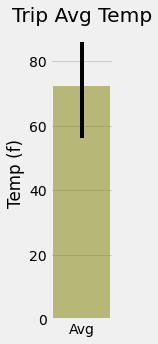

In [134]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
print(stats2012[0][1])


plt.figure(figsize=(1,5))
plt.title('Trip Avg Temp')
plt.bar('Avg',stats2012[0][1],width=0.005,color='olive',alpha=0.5)
plt.vlines('Avg',stats2012[0][0],stats2012[0][2],colors='black')
plt.ylabel('Temp (f)')
plt.grid(axis='x')
plt.savefig('Images/temperature.png',bbox_inches='tight')



### Daily Rainfall Average

In [92]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.name, func.sum(Measurement.prcp), Station.latitude,Station.longitude).\
            filter(Station.station == Measurement.station).\
                 filter(Measurement.date > '2011-12-31').filter(Measurement.date<'2013-01-01').\
                    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()


[('MANOA LYON ARBO 785.2, HI US', 122.59000000000006, 21.3331, -157.8025),
 ('WAIHEE 837.5, HI US', 54.900000000000006, 21.45167, -157.84888999999998),
 ('KANEOHE 838.1, HI US', 32.50000000000001, 21.4234, -157.8015),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 27.76000000000004, 21.33556, -157.71139),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 14.469999999999999, 21.5213, -157.8374),
 ('WAIKIKI 717.2, HI US', 14.219999999999976, 21.2716, -157.8168),
 ('UPPER WAHIAWA 874.3, HI US', 9.589999999999996, 21.4992, -158.0111),
 ('HONOLULU OBSERVATORY 702.2, HI US', 9.169999999999995, 21.3152, -157.9992),
 ('PEARL CITY, HI US', 2.26, 21.3934, -157.9751)]

In [93]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [116]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start_date_dt = dt.datetime.strptime(start_date,"%Y-%m-%d")
end_date_dt = dt.datetime.strptime(end_date,"%Y-%m-%d")
numdays = (end_date_dt-start_date_dt).days
date_list_dt = [end_date_dt - dt.timedelta(days=x) for x in range(numdays)]

# Strip off the year and save a list of strings in the format %m-%d
date_list = [i.strftime("%m-%d") for i in date_list_dt]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(i)[0] for i in date_list]
print(normals)


[(71.0, 77.15686274509804, 83.0), (67.0, 76.25, 83.0), (69.0, 76.14814814814815, 82.0), (69.0, 76.71153846153847, 84.0), (70.0, 76.61111111111111, 85.0), (68.0, 75.60377358490567, 84.0)]


In [131]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns={'Min','Avg','Max'})
df['date'] = date_list
df.head()

,Min,Max,Avg,date
0,71.0,77.156863,83.0,08-07
1,67.0,76.250000,83.0,08-06
2,69.0,76.148148,82.0,08-05
3,69.0,76.711538,84.0,08-04
4,70.0,76.611111,85.0,08-03


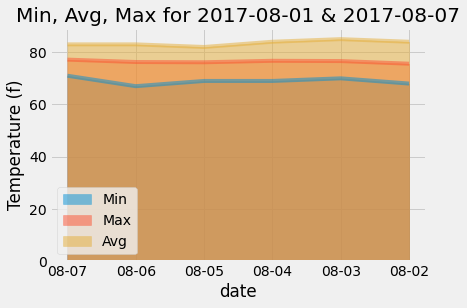

In [133]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area',x='date',stacked=False)
plt.ylabel('Temperature (f)')
plt.title(f'Min, Avg, Max for {start_date} & {end_date}')
plt.savefig('Images/daily-normals.png',bbox_inches='tight')

## Close Session